# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import joblib
import importlib
import copy

import remresAPI.data_loader
data_loader = remresAPI.data_loader
importlib.reload(data_loader)

import remresAPI.preprocessing
preprocessors = remresAPI.preprocessing
importlib.reload(preprocessors)

import remresAPI.processing
processors = remresAPI.processing
importlib.reload(processors)

import remresAPI.pipeline
pipeline = remresAPI.pipeline
importlib.reload(pipeline)

import remresAPI.cue_schema
cue_schema = remresAPI.cue_schema
importlib.reload(cue_schema)

<module 'remresAPI.cue_schema' from 'd:\\Emmanuel_petron_Olateju\\project\\Remres\\notebooks\\remresAPI\\cue_schema.py'>

# Data preprocessing

In [2]:
emg, cue = data_loader.load_all_subjects_data('../dataset/')

## Preprocessing pipeline 1 
*Baseline correction -> rectification -> bandpass filtering*

### Pipeline

In [3]:
preprocessing_pipeline_1 = pipeline.Pipeline('preprocessing_pipeline_1',[
    preprocessors.baselineCorrection('baseline_corrector'),
    preprocessors.rectification('rectifier'),
    preprocessors.filtering('300Hz_lp_filter',1000,0,300,4,'lowpass'),
])

_ = preprocessing_pipeline_1.run(emg)

In [4]:
cue = cue_schema.GraspRelease(cue)
print(np.unique(cue))

['grasp' 'release' 'set']


### Analysis of resulting signals

#### comparing before preprocessing to after

Text(0.5, 0.98, 'showing unpreprocessed signal on left vs processed signal on right')

<Figure size 640x480 with 0 Axes>

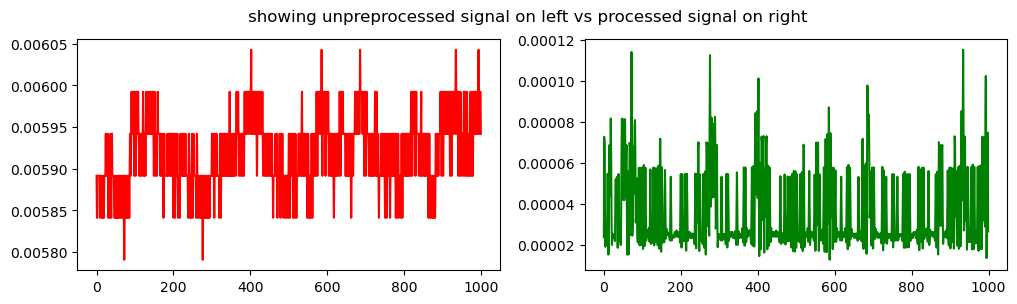

In [5]:
import matplotlib.pyplot as plt
plt.figure()
plt.ion()

fig,ax = plt.subplots(1,2,figsize=(12,3))


i = 1
y = emg[i,:]
y_clean = preprocessing_pipeline_1.output[i,:]
x = np.arange(0,y.shape[-1],1)

ax[0].plot(x,y,'r')
ax[1].plot(x,y_clean,'g')

fig.suptitle('showing unpreprocessed signal on left vs processed signal on right')

#### group level differences

In [6]:
set_index = cue=='set'
grasp_index = cue=='grasp'
release_index = cue=='release'

preprocessing_pipeline_1.results['set_cue_average'] = np.average(preprocessing_pipeline_1.output[set_index],0)
preprocessing_pipeline_1.results['grasp_cue_average'] = np.average(preprocessing_pipeline_1.output[grasp_index],0)
preprocessing_pipeline_1.results['release_cue_average'] = np.average(preprocessing_pipeline_1.output[release_index],0)

plt.ioff()
fig = plt.figure()
plt.plot(preprocessing_pipeline_1.results['set_cue_average'],label='set')
plt.plot(preprocessing_pipeline_1.results['grasp_cue_average'],label='grasp')
plt.plot(preprocessing_pipeline_1.results['release_cue_average'],label='release')
plt.legend()
plt.title('group level difference')
preprocessing_pipeline_1.results['set_grasp_release_group_difference'] = fig
fig = plt.figure()
# plt.plot(set_arr,label='set')
plt.plot(preprocessing_pipeline_1.results['grasp_cue_average'],label='grasp')
plt.plot(preprocessing_pipeline_1.results['release_cue_average'],label='release')
plt.legend()
plt.title('group level difference')
preprocessing_pipeline_1.results['grasp_release_group_difference'] = fig

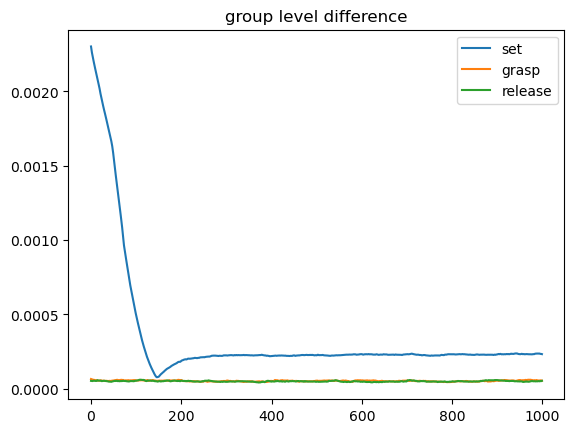

In [7]:
preprocessing_pipeline_1.results['set_grasp_release_group_difference']

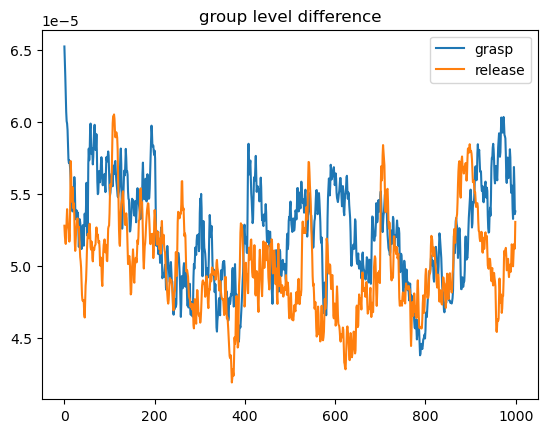

In [8]:
preprocessing_pipeline_1.results['grasp_release_group_difference']

### Save 

In [10]:
joblib.dump(preprocessing_pipeline_1,'../results/preprocessing/preprocessing_pipeline_1.model')

['../results/preprocessing/preprocessing_pipeline_1.model']

# Features

## preprocessing_pipeline_1

### STFT

#### compute STFT feature

In [19]:
X = copy.deepcopy(preprocessing_pipeline_1.output)
__stft = processors.STFT('trial',1000,128)
preprocessing_pipeline_1_stft = preprocessing_pipeline_1.addProcessor(__stft)
preprocessing_pipeline_1_stft.resetName('preprocessing_pipeline_1_stft')
_ = preprocessing_pipeline_1_stft.run(X)

preprocessing_pipeline_1_stft.results['f'] = preprocessing_pipeline_1_stft.output[0]
preprocessing_pipeline_1_stft.results['t'] = preprocessing_pipeline_1_stft.output[1]
preprocessing_pipeline_1_stft.results['magnitude'] = np.absolute(preprocessing_pipeline_1_stft.output[2])
preprocessing_pipeline_1_stft.results['phase'] = np.angle(preprocessing_pipeline_1_stft.output[2])

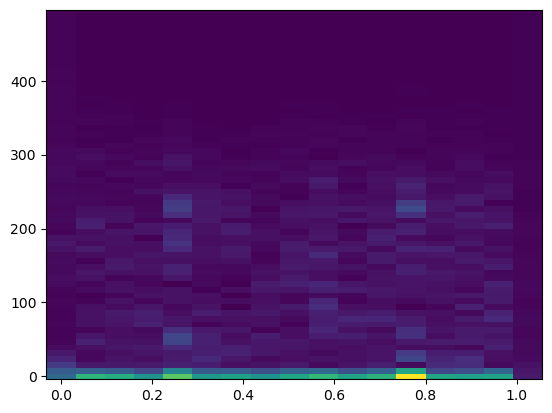

In [20]:
# Briefly snoop into features
import matplotlib.pyplot as plt
plt.ion()
plt.figure()

fs=-1
t = preprocessing_pipeline_1_stft.results['t']
f = preprocessing_pipeline_1_stft.results['f'][:fs]
plt.pcolormesh(t,f,preprocessing_pipeline_1_stft.results['magnitude'][5,:fs,:])

#### group level difference

In [21]:
set_index = cue=='set'
grasp_index = cue=='grasp'
release_index = cue=='release'

preprocessing_pipeline_1_stft.results['set_cue_average'] = np.average(preprocessing_pipeline_1_stft.results['magnitude'][set_index],0)
preprocessing_pipeline_1_stft.results['grasp_cue_average'] = np.average(preprocessing_pipeline_1_stft.results['magnitude'][grasp_index],0)
preprocessing_pipeline_1_stft.results['release_cue_average'] = np.average(preprocessing_pipeline_1_stft.results['magnitude'][release_index],0)

In [ ]:
plt.figure()
plt.ioff()
fig,ax = plt.subplots(1,3,figsize=(18,4))

fs=5
t = preprocessing_pipeline_1_stft.results['t']
f = preprocessing_pipeline_1_stft.results['f'][:fs]

ax[0].pcolormesh(t,f,preprocessing_pipeline_1_stft.results['set_cue_average'][:fs,:],shading='gouraud')
ax[0].set_ylabel('frequency')
ax[1].pcolormesh(t,f,preprocessing_pipeline_1_stft.results['grasp_cue_average'][:fs,:],shading='gouraud')
ax[2].pcolormesh(t,f,preprocessing_pipeline_1_stft.results['release_cue_average'][:fs,:],shading='gouraud')
ax[0].set_xlabel('time')
ax[1].set_xlabel('time')
ax[2].set_xlabel('time')
ax[0].set_title('set')
ax[1].set_title('grasp')
ax[2].set_title('release')

fig.suptitle('STFT group level difference')

preprocessing_pipeline_1_stft.results['stft_group_level_difference'] = fig

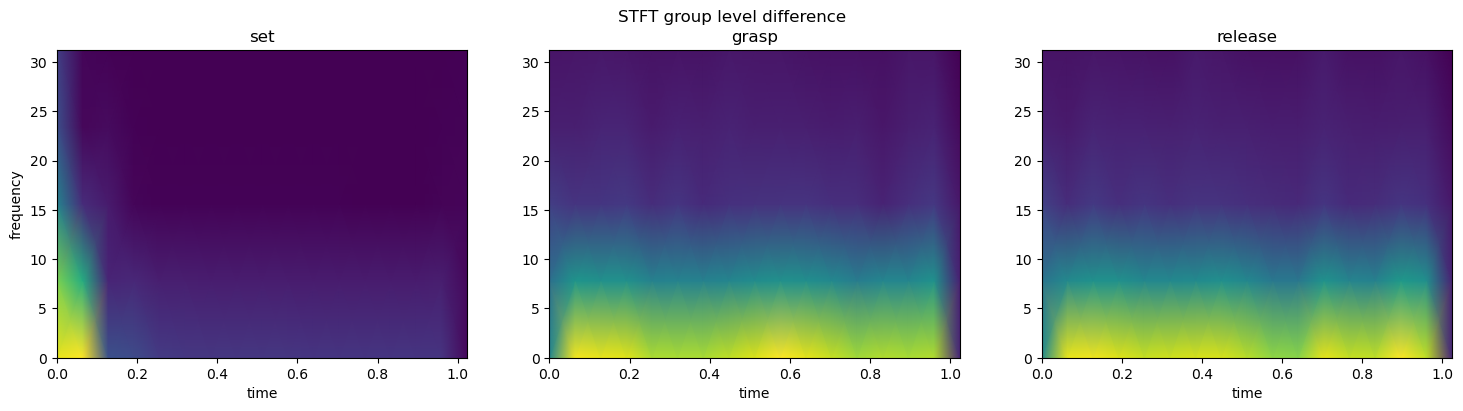

In [23]:
preprocessing_pipeline_1_stft.results['stft_group_level_difference']

#### Save

In [31]:
joblib.dump(preprocessing_pipeline_1_stft,'../results/features/preprocessing_pipeline_1_stft.model')

['../results/features/preprocessing_pipeline_1_stft.model']

### Wavelet

#### Compute wavelet features

In [39]:
from scipy.signal import ricker
from scipy.signal import morlet

X = copy.deepcopy(preprocessing_pipeline_1.output)
__cwt = processors.Wavelet('wavelet_trial',np.arange(1,31),morlet)
preprocessing_pipeline_1_cwt = preprocessing_pipeline_1.addProcessor(__cwt)
preprocessing_pipeline_1_cwt.resetName('preprocessing_pipeline_1_cwt')
_ = preprocessing_pipeline_1_cwt.run(X)
preprocessing_pipeline_1_cwt.results['magnitude'] = np.absolute(preprocessing_pipeline_1_cwt.output)
preprocessing_pipeline_1_cwt.results['phase'] = np.angle(preprocessing_pipeline_1_cwt.output)

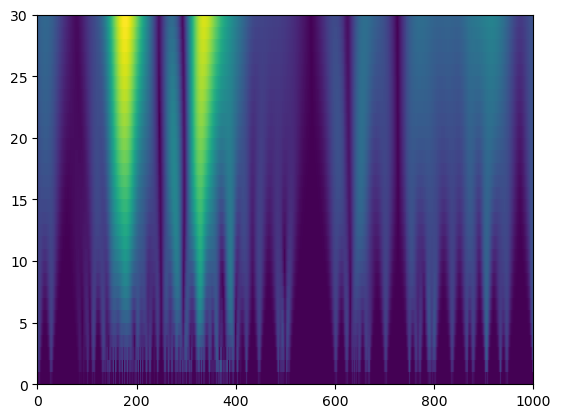

In [42]:
#Briefly snoop into features
import matplotlib.pyplot as plt
plt.ion()
plt.figure()

plt.pcolormesh(preprocessing_pipeline_1_cwt.results['magnitude'][811,:,:])

In [43]:
set_index = cue=='set'
grasp_index = cue=='grasp'
release_index = cue=='release'

preprocessing_pipeline_1_cwt.results['set_cue_average'] = np.average(preprocessing_pipeline_1_cwt.results['magnitude'][set_index],0)
preprocessing_pipeline_1_cwt.results['grasp_cue_average'] = np.average(preprocessing_pipeline_1_cwt.results['magnitude'][grasp_index],0)
preprocessing_pipeline_1_cwt.results['release_cue_average'] = np.average(preprocessing_pipeline_1_cwt.results['magnitude'][release_index],0)

In [46]:
plt.ioff()
plt.figure()
fig,ax = plt.subplots(1,3,figsize=(18,4))

ax[0].pcolormesh(preprocessing_pipeline_1_cwt.results['set_cue_average'],shading='gouraud')
ax[0].set_ylabel('frequency')
ax[1].pcolormesh(preprocessing_pipeline_1_cwt.results['grasp_cue_average'],shading='gouraud')
ax[2].pcolormesh(preprocessing_pipeline_1_cwt.results['release_cue_average'],shading='gouraud')
ax[0].set_xlabel('time')
ax[1].set_xlabel('time')
ax[2].set_xlabel('time')
ax[0].set_title('set')
ax[1].set_title('grasp')
ax[2].set_title('release')

fig.suptitle('CWT group level difference')

preprocessing_pipeline_1_cwt.results['cwt_group_level_difference'] = fig

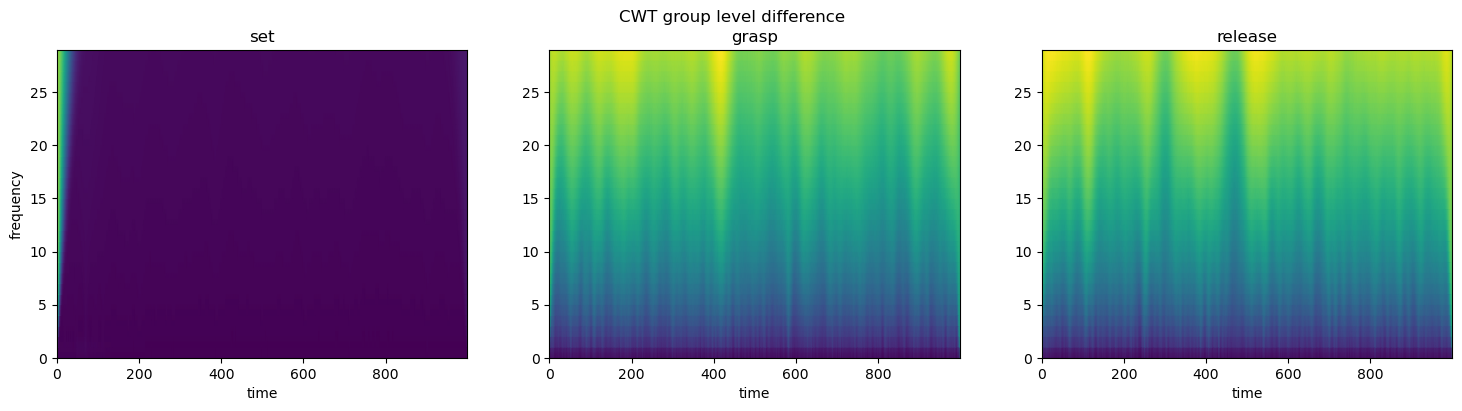

In [47]:
preprocessing_pipeline_1_cwt.results['cwt_group_level_difference']

#### Save

In [48]:
joblib.dump(preprocessing_pipeline_1_cwt,'../results/features/preprocessing_pipeline_1_cwt.model')

['../results/features/preprocessing_pipeline_1_cwt.model']

### PSD

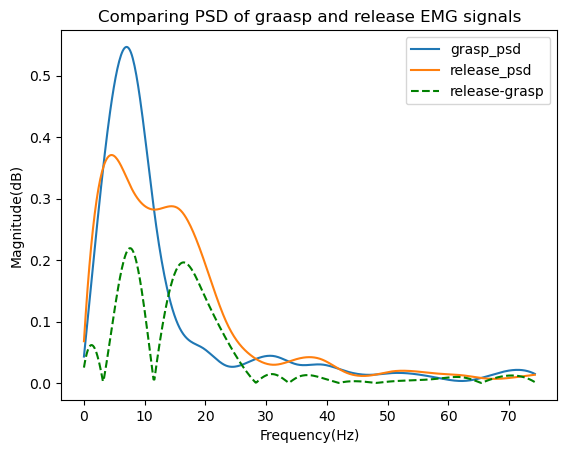

In [84]:
from scipy.signal import welch
from scipy.interpolate import make_interp_spline

fs_2 = 20

preprocessing_pipeline_1.results['average_grasp_cue_psd'] = x1 = welch(preprocessing_pipeline_1.results['grasp_cue_average'],fs=1000,scaling='spectrum')
preprocessing_pipeline_1.results['average_release_cue_psd'] = x2 = welch(preprocessing_pipeline_1.results['release_cue_average'],fs=1000,scaling='spectrum')
preprocessing_pipeline_1.results['average_set_cue_psd'] = x3 = welch(preprocessing_pipeline_1.results['set_cue_average'],fs=1000,scaling='spectrum')
plt.figure()

X1_Y1_Spline = make_interp_spline(x1[0][:fs_2],abs(x1[1][:fs_2]/6E-12))
x1 = np.linspace(x1[0][:fs_2].min(),x1[0][:fs_2].max(),500)
y1 = X1_Y1_Spline(x1)
plt.plot(x1,y1,label='grasp_psd')
X2_Y2_Spline = make_interp_spline(x2[0][:fs_2],abs(x2[1][:fs_2]/6E-12))
x2 = np.linspace(x2[0][:fs_2].min(),x2[0][:fs_2].max(),500)
y2 = X2_Y2_Spline(x2)
plt.plot(x2,y2,label='release_psd')
plt.plot(x1,abs(y2-y1),'g--',label='release-grasp')
plt.xlabel('Frequency(Hz)')
plt.ylabel('Magnitude(dB)')
plt.title('Comparing PSD of graasp and release EMG signals')
plt.legend()
plt.show()